# 3.16 实战Kaggle比赛：房价预测

作为深度学习基础篇章的总结，我们将对本章内容学以致用。下面，让我们动手实战一个Kaggle比赛：房价预测。本节将提供未经调优的数据的预处理、模型的设计和超参数的选择。我们希望读者通过动手操作、仔细观察实验现象、认真分析实验结果并不断调整方法，得到令自己满意的结果。

## 3.16.1 Kaggle比赛

[Kaggle](https://www.kaggle.com)是一个著名的供机器学习爱好者交流的平台。图3.7展示了Kaggle网站的首页。为了便于提交结果，需要注册Kaggle账号。

## 3.16.2 获取和读取数据集

比赛数据分为训练数据集和测试数据集。两个数据集都包括每栋房子的特征，如街道类型、建造年份、房顶类型、地下室状况等特征值。这些特征值有连续的数字、离散的标签甚至是缺失值“na”。只有训练数据集包括了每栋房子的价格，也就是标签。我们可以访问比赛网页，点击图3.8中的“Data”标签，并下载这些数据集。

我们将通过`pandas`库读入并处理数据。在导入本节需要的包前请确保已安装`pandas`库，否则请参考下面的代码注释。

In [190]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys

sys.path.append("..") 
import d2lzh_pytorch as d2l

print(torch.__version__)

torch.set_default_tensor_type(torch.FloatTensor)

1.13.1+cu117


In [191]:
train_data = pd.read_csv('~/Datasets/kaggle_house/train.csv')

test_data = pd.read_csv('~/Datasets/kaggle_house/test.csv')

训练数据集包括1460个样本、80个特征和1个标签。

测试数据集包括1459个样本和80个特征。我们需要将测试数据集中每个样本的标签预测出来。

可以看到第一个特征是Id，它能帮助模型记住每个训练样本，但难以推广到测试样本，所以我们不使用它来训练。我们将所有的训练数据和测试数据的79个特征按样本连结。

In [192]:
# 不要 id, y 标签数据
trainData_not_label = train_data.iloc[:, 1:-1]

# 不要 id 数据. (test没y数据)
testData_not_label = test_data.iloc[:, 1:]


# 得到全部特征
all_features = pd.concat((trainData_not_label, 
                          testData_not_label
                         ))

## 3.16.3 预处理数据

我们对连续数值的特征做标准化（standardization）：设该特征在整个数据集上的均值为$\mu$，标准差为$\sigma$。那么，我们可以将该特征的每个值先减去$\mu$再除以$\sigma$得到标准化后的每个特征值。对于缺失的特征值，我们将其替换成该特征的均值。

In [193]:

# 这里只提取 数字类型的特征
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

In [194]:

# 只有36行的 数字类型特征
features_36 = all_features[numeric_features]


# 特征值标准化
all_features[numeric_features] = features_36.apply(lambda x: (x - x.mean()) / (x.std()))


In [195]:
# 标准化后，每个数值特征的均值变为 0，所以可以直接用 0 来替换缺失值

all_features[numeric_features] = all_features[numeric_features].fillna(0)

接下来将离散数值转成指示特征。举个例子，假设特征MSZoning里面有两个不同的离散值RL和RM，那么这一步转换将去掉MSZoning特征，并新加两个特征MSZoning\_RL和MSZoning\_RM，其值为0或1。如果一个样本原来在MSZoning里的值为RL，那么有MSZoning\_RL=1且MSZoning\_RM=0。

In [196]:
# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征


# 将 object 等描述性特征, 转成 int类型特征
all_features = pd.get_dummies(all_features, dummy_na=True)


# 
all_features.shape # (2919行数据, 331个特征)

(2919, 331)

可以看到这一步转换将特征数从79增加到了331。

最后，通过`values`属性得到NumPy格式的数据，并转成`Tensor`方便后面的训练。

In [197]:
n_train = train_data.shape[0]  # 1460


# 0 - 1460 条训练数据. 有 y 数据
all_features[:n_train].values.shape

(1460, 331)

In [198]:
# [1460: ] 测试数据

all_features[n_train:].values.shape

(1459, 331)

In [199]:
n_train = train_data.shape[0]  # 1460


train_data_1460 = all_features[:n_train].values  # 1460 条
test_data_1459 = all_features[n_train:].values   # 1459 条


train_features = torch.tensor(train_data_1460, dtype=torch.float)
test_features  = torch.tensor(test_data_1459, dtype=torch.float)


train_labels = torch.tensor(train_data.SalePrice.values, 
                            dtype=torch.float
                           ).view(-1, 1)

## 3.16.4 训练模型

我们使用一个基本的线性回归模型和平方损失函数来训练模型。

In [200]:

def get_net(feature_num):

    net = nn.Linear(feature_num, 1)
    
    # 一并初始化模型参数
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)

    return net

下面定义比赛用来评价模型的对数均方根误差。给定预测值$\hat y_1, \ldots, \hat y_n$和对应的真实标签$y_1,\ldots, y_n$，它的定义为

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log(y_i)-\log(\hat y_i)\right)^2}.$$

对数均方根误差的实现如下。

In [201]:
loss = torch.nn.MSELoss()


# 对数均方根误差
def log_rmse(net, features, labels):
    
    with torch.no_grad():
        
        # 将小于1的值设成1，使得取对数时数值更稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        
        rmse = torch.sqrt(loss(clipped_preds.log(), labels.log()))
        
        pass
    
    return rmse.item()

下面的训练函数跟本章中前几节的不同在于使用了Adam优化算法。相对之前使用的小批量随机梯度下降，它对学习率相对不那么敏感。我们将在之后的“优化算法”一章里详细介绍它。

In [202]:


def train(net, train_features, train_labels, 
          test_features, test_labels,
          num_epochs, learning_rate,
          weight_decay, 
          batch_size
         ):
    
    train_ls = []
    test_ls = []
    
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    
    # 这里使用了Adam优化算法
    optimizer = torch.optim.Adam(params=net.parameters(),
                                 lr=learning_rate,
                                 weight_decay=weight_decay  # 权重衰减
                                )
    net = net.float()
    
    # 训练
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            pass
        
        
        # 损失计算
        loss_t = log_rmse(net, train_features, train_labels)
        train_ls.append(loss_t)
        
        if test_labels is not None:
            loss_t = log_rmse(net, test_features, test_labels)
            test_ls.append(loss_t)
        pass
    
    return train_ls, test_ls

## 3.16.5 $K$折交叉验证

我们在3.11节（模型选择、欠拟合和过拟合）中介绍了$K$折交叉验证。它将被用来选择模型设计并调节超参数。下面实现了一个函数，它返回第`i`折交叉验证时所需要的训练和验证数据。

In [203]:
def get_k_fold_data(k, i, X, y):
    # 返回第 i折交叉验证 时所需要的训练和验证数据
    
    assert k > 1
    
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
        pass
    
    return X_train, y_train, X_valid, y_valid

在$K$折交叉验证中我们训练$K$次并返回训练和验证的平均误差。

In [204]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    
    train_l_sum = 0
    valid_l_sum = 0
    
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        
        # 训练
        train_ls, valid_ls = train(net, 
                                   *data, 
                                   num_epochs, 
                                   learning_rate,
                                   weight_decay, 
                                   batch_size
                                  )
        
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        
        # 打印
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
            
        # 打印
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
        pass

    return train_l_sum / k, valid_l_sum / k

## 3.16.6 模型选择

我们使用一组未经调优的超参数并计算交叉验证误差。可以改动这些超参数来尽可能减小平均测试误差。

fold 0, train rmse 0.170475, valid rmse 0.156819
fold 1, train rmse 0.162313, valid rmse 0.191115
fold 2, train rmse 0.164032, valid rmse 0.168453
fold 3, train rmse 0.167727, valid rmse 0.154483
fold 4, train rmse 0.163836, valid rmse 0.182925
5-fold validation: avg train rmse 0.165677, avg valid rmse 0.170759


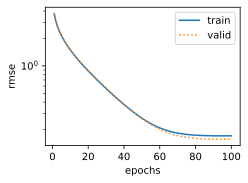

In [205]:
k = 5
num_epochs = 100

lr = 5

weight_decay = 0
batch_size = 64



# 启动
train_l, valid_l = k_fold(k, 
                          train_features, 
                          train_labels, 
                          num_epochs, 
                          lr, 
                          weight_decay, 
                          batch_size
                         )


print('%d-fold validation: avg train rmse %f, avg valid rmse %f' 
      % (k, train_l, valid_l))

有时候你会发现一组参数的训练误差可以达到很低，但是在$K$折交叉验证上的误差可能反而较高。这种现象很可能是由过拟合造成的。因此，当训练误差降低时，我们要观察$K$折交叉验证上的误差是否也相应降低。

## 3.16.7 预测并在Kaggle提交结果

下面定义预测函数。在预测之前，我们会使用完整的训练数据集来重新训练模型，并将预测结果存成提交所需要的格式。

In [206]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    
    # 模型选择
    net = get_net(train_features.shape[1])
    
    
    # 训练
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, 
                        weight_decay, 
                        batch_size
                       )
    
    
    # 
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
                 
    print('train rmse %f' % train_ls[-1])
    
    preds = net(test_features).detach().numpy()
                 
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
                 
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
                 
    submission.to_csv('./submission.csv', index=False)

设计好模型并调好超参数之后，下一步就是对测试数据集上的房屋样本做价格预测。如果我们得到与交叉验证时差不多的训练误差，那么这个结果很可能是理想的，可以在Kaggle上提交结果。

train rmse 0.162556


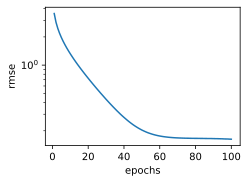

In [207]:
k = 5
num_epochs = 100

lr = 5
weight_decay = 0
batch_size = 64



train_and_pred(train_features, test_features, 
               train_labels, test_data, 
               num_epochs, lr, 
               weight_decay, batch_size
              )

上述代码执行完之后会生成一个submission.csv文件。这个文件是符合Kaggle比赛要求的提交格式的。这时，我们可以在Kaggle上提交我们预测得出的结果，并且查看与测试数据集上真实房价（标签）的误差。具体来说有以下几个步骤：登录Kaggle网站，访问房价预测比赛网页，并点击右侧“Submit Predictions”或“Late Submission”按钮；然后，点击页面下方“Upload Submission File”图标所在的虚线框选择需要提交的预测结果文件；最后，点击页面最下方的“Make Submission”按钮就可以查看结果了，如图3.9所示。

## 小结

* 通常需要对真实数据做预处理。
* 可以使用$K$折交叉验证来选择模型并调节超参数。